<a href="https://colab.research.google.com/github/ASerraMartin/SAC_Spark/blob/main/SAC_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports and Spark environment setup**

In [180]:
from pyspark import SparkContext, SparkConf
from string import ascii_uppercase
import matplotlib.pyplot as plt
import networkx as nx
import random

### **Auxiliary functions**

#### Graph generation function
Sourced from:
https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html

In [181]:
def generate_random_graph(n, p, weight_range):
  """
  Generates a random directed graph, with n nodes, p probability of connection between node pairs
  and random edge weights whitin the specified range (weight_range).
  """

  # Generate the random directed graph, with numbers as node names
  G_numbers = nx.gnp_random_graph(n, p, directed=True)

  # Map the node names to letters, ordered alphabetically
  mapping = {i: ascii_uppercase[i] for i in range(n)}
  G_letters = nx.relabel_nodes(G_numbers, mapping)

  # Add random weights, within the specified range, to the edges
  for (u, v) in G_letters.edges():
    G_letters.edges[u, v]['weight'] = int(random.randint(*weight_range))

  return G_letters

#### Graph preprocessing function

In [182]:
def preprocess_pyspark_graph(G, source_node):
  """
  Converts a NetworkX graph G into a list format compatible with PySpark. The specified
  source node will serve as the initial node for the Dijkstra shortest-path algorithm.
  """

  pyspark_graph = []

  for node in G.nodes():

    # Get a tuple list of (neighbor, weight) for all neighboring nodes
    neighbors = [(nbr, G.edges[node, nbr]["weight"]) for nbr in G.successors(node)]

    # Initialize the node's distance (0 for the source, infinite otherwise)
    initial_weight = 0 if node == source_node else float("inf")

    # Establish the node's initial state
    state = (
        neighbors,
        initial_weight,
        False, # Not processed
        [],    # No history of visited nodes
    )

    pyspark_graph.append((node, state))

  return pyspark_graph

#### Graph plotting and printing functions

In [183]:
def plot_graph(G):
  """
  Plots the given NetworkX directed graph (networkx.DiGraph) G, naming each node
  and showing every edge between nodes as an arrow with its associated weight.
  """

  # Establish a general purpose layout for any graph
  layout = nx.circular_layout(G)

  # Plot the nodes
  nx.draw_networkx_nodes( G, layout, node_color= 'lightblue', node_size=300)
  nx.draw_networkx_labels(G, layout)

  # Plot the edges
  nx.draw_networkx_edges(G, layout, edge_color='gray', width=0.5)
  nx.draw_networkx_edge_labels(G, layout, edge_labels=nx.get_edge_attributes(G, 'weight'))

  plt.show()

In [184]:
def print_pyspark_data(data):
  """
  Prints a formatted output of the given data from a PySpark-format directed graph.
  """

  # Header with aligned columns
  print(f"{'='*50}")
  print(f"{'Node':<5} | {'Weight':<10} | {'Neighbors (Dest, Cost)'}")
  print(f"{'-'*50}")

  # Each node, also with aligned columns
  for node, (neighbors, weight, _, _) in data:

      # Formats for the weight and list of neighbors
      weight_str = "inf" if weight == float('inf') else f"{weight:.1f}"
      neighbors_str = ", ".join([f"({u}, {v})" for u, v in neighbors])

      print(f"{node:<5} | {weight_str:<10} | {neighbors_str}")

  print(f"\n")

### **Initial graph construction**

#### Generation

In [185]:
# Given example graph
G = nx.DiGraph()
G.add_weighted_edges_from([
    ("A", "B", 3), ("A", "C", 10), ("A", "E", 4),
    ("B", "C", 2), ("B", "D", 8),  ("B", "F", 7),
    ("C", "D", 5), ("C", "G", 3),
    ("D", "H", 6),
    ("E", "F", 2), ("E", "I", 9),
    ("F", "G", 1), ("F", "J", 5),
    ("G", "H", 2), ("G", "K", 4),
    ("I", "J", 3),
    ("J", "K", 6)
])

# Example of a randomly generated graph
G_rand = generate_random_graph(10, 0.15, (1, 10))

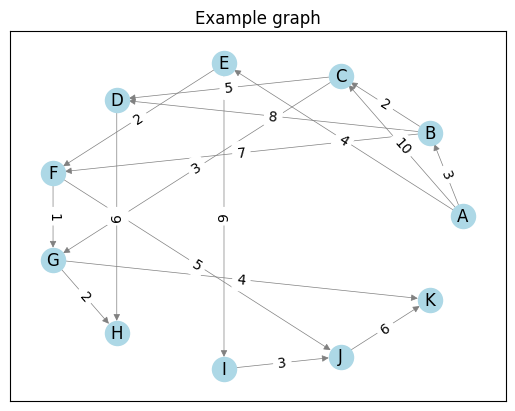

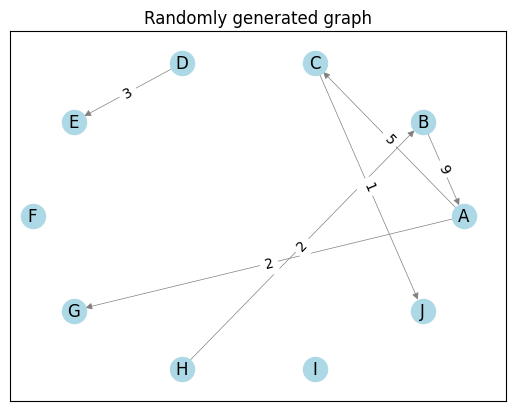

In [186]:
plt.figure(1)
plt.title("Example graph")
plot_graph(G)

plt.figure(2)
plt.title("Randomly generated graph")
plot_graph(G_rand)

#### Pre-processing

In [187]:
G_pyspark = preprocess_pyspark_graph(G, "A")
G_rand_pyspark = preprocess_pyspark_graph(G_rand, "A")

In [188]:
print("EXAMPLE GRAPH")
print_pyspark_data(G_pyspark)

print("GENERATED GRAPH")
print_pyspark_data(G_rand_pyspark)

EXAMPLE GRAPH
Node  | Weight     | Neighbors (Dest, Cost)
--------------------------------------------------
A     | 0.0        | (B, 3), (C, 10), (E, 4)
B     | inf        | (C, 2), (D, 8), (F, 7)
C     | inf        | (D, 5), (G, 3)
E     | inf        | (F, 2), (I, 9)
D     | inf        | (H, 6)
F     | inf        | (G, 1), (J, 5)
G     | inf        | (H, 2), (K, 4)
H     | inf        | 
I     | inf        | (J, 3)
J     | inf        | (K, 6)
K     | inf        | 


GENERATED GRAPH
Node  | Weight     | Neighbors (Dest, Cost)
--------------------------------------------------
A     | 0.0        | (C, 5), (G, 2)
B     | inf        | (A, 9)
C     | inf        | (J, 1)
D     | inf        | (E, 3)
E     | inf        | 
F     | inf        | 
G     | inf        | 
H     | inf        | (B, 2)
I     | inf        | 
J     | inf        | 




### **Dijkstra shortest-path iterative algorithm**